# Autoencoders for image cleaning

Example of training a custom Autoencoder neural network for simple image cleaning using [AtomAI](https://github.com/pycroscopy/atomai) trainers. 

---


*  *Notebook prepared by Maxim Ziatdinov  (email: ziatdinivmax@gmail.com)*

*  The simulated data (atomic coordinates) comes from MD calculations by Bobby Sumpter and Ayana Ghosh*

---





Generally, autoencoders refer to the class of the neural networks that compress the data set to a small number of bottleneck features, and then expand back to original data size. The training aims to minimize information loss between the initial and reconstructed images via usual
backpropagation. This process tends to select the relevant features in the data set and reject the noise, giving rise to applications for denoising.

Install AtomAI:

In [ ]:
!pip install git+https://github.com/ziatdinovmax/atomai@refactoring --upgrade

  Cloning https://github.com/ziatdinovmax/atomai (to revision refactoring) to /tmp/pip-req-build-40rd6iii
  Running command git clone -q https://github.com/ziatdinovmax/atomai /tmp/pip-req-build-40rd6iii
  Running command git checkout -b refactoring --track origin/refactoring
  Switched to a new branch 'refactoring'
  Branch 'refactoring' set up to track remote branch 'refactoring' from 'origin'.
     |████████████████████████████████| 194kB 12.8MB/s 
     |████████████████████████████████| 870kB 17.0MB/s 
  Created wheel for atomai: filename=atomai-0.5.9-cp36-none-any.whl size=126840 sha256=443cb9b6fb52a4190c0a91d9e1f3c00e7e107a95cffba562c2b6d9ff58dc089b
  Stored in directory: /tmp/pip-ephem-wheel-cache-ml9g2tou/wheels/07/c1/a0/bb2931940382974a8fd91344bb9587ab720a9fdbe3e5e5ab90
  Created wheel for mendeleev: filename=mendeleev-0.6.1-py2.py3-none-any.whl size=174964 sha256=d5ef50881de0cd88652bdb1f613f47881707647141ed3dbe9fad3e9fe3ad3698
  Stored in directory: /root/.cache/pip/wheels/fb

Imports:

In [ ]:
import atomai as aoi
from atomai.nets import ConvBlock, UpsampleBlock
from atomai.utils import set_train_rng

import torch
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

Down(load) simulated data of graphene:

In [ ]:
# DOwnload into VM storage
!gdown "https://drive.google.com/uc?id=1iFZvHKkOLWxPVe6dlm5GTJOSimAZJCMf"
# Load data into the notebook:
imgdata = np.load("cropped_images_new.npy")[::3] # take ~1/3 of the data

Downloading...
From: https://drive.google.com/uc?id=1iFZvHKkOLWxPVe6dlm5GTJOSimAZJCMf
To: /content/cropped_images_new.npy
3.17GB [00:46, 68.0MB/s]


Add noise:

In [ ]:
# Add noise to data
imgdata_noisy = imgdata + np.random.normal(scale=8, size=imgdata.shape)
# Normalize to (0,1) so that stochastic gradient decent will behave nicely
norm = lambda x: (x - x.min()) / x.ptp()
imgdata, imgdata_noisy = norm(imgdata), norm(imgdata_noisy)

View selected pairs of images (images on the left side will be input into a neural network and images on the right side will be our targets)

Text(0.5, 1.0, 'Corrupted image')

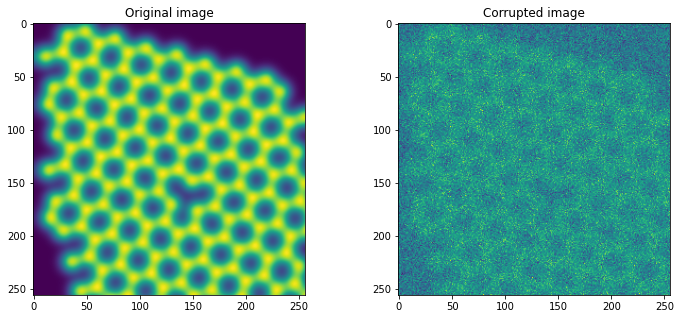

In [ ]:
k = 15

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(imgdata[k])
ax2.imshow(imgdata_noisy[k])
ax1.set_title("Original image")
ax2.set_title("Corrupted image")

Use AtomAI's utility function to convert to the format used by PyTorch:

In [ ]:
data_ = aoi.utils.data_split(imgdata, imgdata_noisy,format_out="torch_float", channel="first")
imgdata, imgdata_noisy, imgdata_test, imgdata_noisy_test = data_

Here we define our [denosing autoencoder](https://en.wikipedia.org/wiki/Autoencoder#Denoising_autoencoder_(DAE)) combining AtomAI's building blcoks for neural networks and native PyTorch modules:

In [ ]:
torch_encoder = torch.nn.Sequential(
    ConvBlock(ndim=2, nb_layers=1, input_channels=1, output_channels=8, batch_norm=True),
    torch.nn.MaxPool2d(2, 2),
    ConvBlock(2, 2, 8, 16, batch_norm=False),
    torch.nn.MaxPool2d(2, 2),
    ConvBlock(2, 2, 16, 32, batch_norm=False),
    torch.nn.MaxPool2d(2, 2),
    ConvBlock(2, 2, 32, 64, batch_norm=False)  # technically, this is a "bottleneck layer"
)

torch_decoder = torch.nn.Sequential(
    UpsampleBlock(ndim=2, input_channels=64, output_channels=64, mode="nearest"), # bilinear mode is better but leads to uncontrolled randomness on CPU
    ConvBlock(2, 2, 64, 32, batch_norm=False),
    UpsampleBlock(2, 32, 32, mode="nearest"),  # we can also use it to reduce numbe of "channels"
    ConvBlock(2, 2, 32, 16, batch_norm=False),
    UpsampleBlock(2, 16, 16, mode="nearest"),
    ConvBlock(2, 1, 16, 8, batch_norm=False),
    torch.nn.Conv2d(8, 1, 1) # vanilla 2D convolutional layer without activation
)

torch_DAE = torch.nn.Sequential(torch_encoder, torch_decoder)

Next we initialize AtomAI's trainer and pass our model to it:

In [ ]:
trainer = aoi.trainers.BaseTrainer()
trainer.set_model(torch_DAE)

Compile a trainer:

In [ ]:
# The next three lines are to ensure that we start from the same state of the model every time
set_train_rng(1)
trainer._reset_weights()
trainer._reset_training_history()

trainer.compile_trainer(
    (imgdata_noisy, imgdata, imgdata_noisy_test, imgdata_test), # training data
    loss="mse", training_cycles=500, swa=True  # training parameters
)

Finally, we train a model:

Epoch 1 ... Training loss: 0.0834 ... Test loss: 0.0715 ... GPU memory usage: 2787/16130
Epoch 100 ... Training loss: 0.0026 ... Test loss: 0.0048 ... GPU memory usage: 2787/16130
Epoch 200 ... Training loss: 0.002 ... Test loss: 0.0021 ... GPU memory usage: 2787/16130
Epoch 300 ... Training loss: 0.0013 ... Test loss: 0.001 ... GPU memory usage: 2787/16130
Epoch 400 ... Training loss: 0.0008 ... Test loss: 0.0007 ... GPU memory usage: 2787/16130
Epoch 500 ... Training loss: 0.0012 ... Test loss: 0.0019 ... GPU memory usage: 2787/16130
Model (final state) evaluation loss: 0.0019
Performing stochastic weights averaging...
Model (final state) evaluation loss: 0.0009
Plotting training history


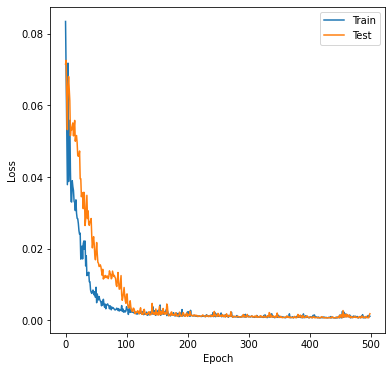

In [ ]:
trained_model = trainer.run()

Make a prediction with the trained model using AtomAI's predictor class:

In [ ]:
p = aoi.predictors.BasePredictor(trained_model, use_gpu=True)
prediction = p.predict(imgdata_noisy_test)

Text(0.5, 1.0, 'Cleaned data')

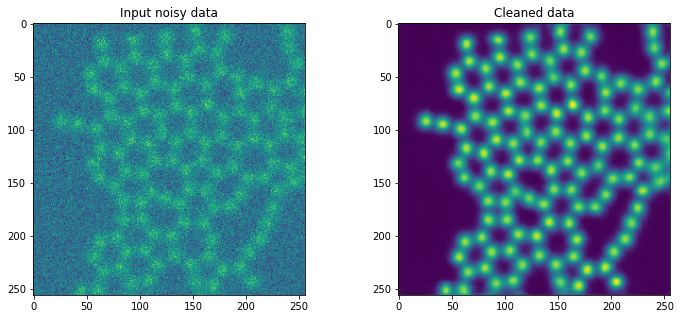

In [ ]:
k = 15
# plot results
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(imgdata_noisy_test[k,0].cpu())
ax2.imshow(prediction[k,0].cpu())
ax1.set_title("Input noisy data")
ax2.set_title("Cleaned data")

Looks clean!